# Model selection

In [1]:
using Revise

In [2]:
using RxInfer, Distributions, Random, PyPlot

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1662


### Data generation

In [3]:
# specify distribution
dist = MixtureModel(Normal, [(-2.0, 1.0), (0.0, 1.0), (3.0, 1.0)], [0.2, 0.5, 0.3]);

In [4]:
function generate_data(dist, nr_samples; rng=MersenneTwister(123))

    # sample from distribution
    samples = rand(rng, dist, nr_samples)

    # return samples
    return samples

end;

In [5]:
data = generate_data(dist, 1)

1-element Vector{Float64}:
 3.003103090722938

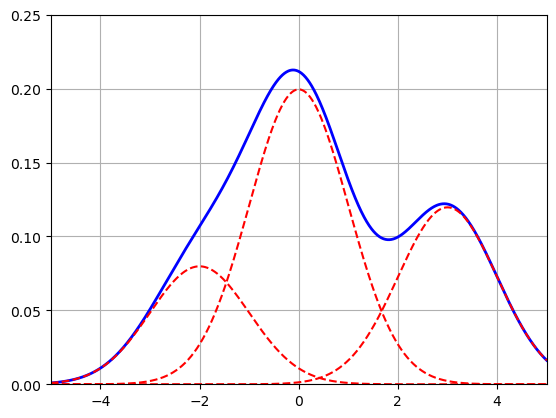

(0.0, 0.25)

In [6]:
plt.plot(-5:0.01:5, map(x -> pdf(dist, x), -5:0.01:5), color="blue", linewidth=2)
plt.hist(data, density="relative", bins=200, alpha=0.5)
plt.plot(-5:0.01:5, map(x -> dist.prior.p[1]*pdf(dist.components[1], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[2]*pdf(dist.components[2], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[3]*pdf(dist.components[3], x), -5:0.01:5), color="red", linestyle="--")
plt.grid()
plt.xlim(-5, 5)
plt.ylim(0, 0.25)

In [13]:
@model function model_selection(nr_samples)

    # specify experimental outcomes
    y = datavar(Float64, nr_samples)

    # specify John's and Jane's prior models over θ
    θ1 ~ NormalMeanPrecision(-5, 0.01)
    θ2 ~ NormalMeanPrecision(0, 0.01)
    θ3 ~ NormalMeanPrecision(5, 0.01)

    # specify initial guess as to who is right
    prior ~ Categorical([1/3, 1/6, 1/2])

    # specify mixture prior Distribution
    θ ~ Switch(prior, (θ1, θ2, θ3)) where { pipeline = RequireMarginal(switch) }

    # create likelihood models
    for i in 1:nr_samples
        y[i] ~ NormalMeanPrecision(θ, 1.0)
    end

    return y, θ, θ1, θ2, θ3, prior

end

In [14]:
model = model_selection(1)

RxInfer.ModelGenerator{var"###model_selection#331", Tuple{Int64}, NamedTuple{(), Tuple{}}}(var"##model_selection#331", (1,), NamedTuple())

In [15]:
@constraints function constraints_selection()
    q(prior) :: PointMass
end

constraints_selection (generic function with 1 method)

In [31]:
results_selection = inference(
    model = model_selection(1),
    constraints = constraints_selection(),
    data  = (y = data, ),
    returnvars = (θ = KeepLast(), θ1 = KeepLast(), θ2 = KeepLast(), θ3 = KeepLast(), prior=KeepLast()),
    options = ( addons = (AddonLogScale(),), )
)

(ReactiveMP.FactorNodeLocalMarginal(2, 2, :μ, nothing), ReactiveMP.FactorNodeLocalMarginal(3, 3, :τ, nothing))
(ReactiveMP.FactorNodeLocalMarginal(2, 2, :μ, nothing), ReactiveMP.FactorNodeLocalMarginal(3, 3, :τ, nothing))
(ReactiveMP.FactorNodeLocalMarginal(2, 2, :μ, nothing), ReactiveMP.FactorNodeLocalMarginal(3, 3, :τ, nothing))
(ReactiveMP.FactorNodeLocalMarginal(2, 2, :p, nothing),)
(Interface(switch, Marginalisation()),)


LoadError: MethodError: no method matching getmarginal!(::SwitchNode{3, FullFactorisation, Nothing, ReactiveMP.FactorNodePipeline{ReactiveMP.RequireMarginalFunctionalDependencies{Tuple{Int64}, Tuple{Nothing}}, EmptyPipelineStage}}, ::ReactiveMP.NodeInterface, ::IncludeAll)
[0mClosest candidates are:
[0m  getmarginal!([91m::ReactiveMP.FactorNode[39m, [91m::ReactiveMP.FactorNodeLocalMarginal[39m, ::ReactiveMP.MarginalSkipStrategy) at d:\OneDrive - TU Eindhoven\phd\Projects\Packages\ReactiveMP.jl\src\node.jl:912
[0m  getmarginal!(::SwitchNode, [91m::ReactiveMP.FactorNodeLocalMarginal[39m) at d:\OneDrive - TU Eindhoven\phd\Projects\Packages\ReactiveMP.jl\src\nodes\switch.jl:55

In [ ]:
results_selection.posteriors[:prior]

In [ ]:
results_selection.posteriors[:θ1]

In [ ]:
results_selection.posteriors[:θ2]

In [ ]:
results_selection.posteriors[:θ3]